In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker

In [2]:
! radical-stack


  python               : 3.8.7
  pythonpath           : 
  virtualenv           : /Users/mturilli/.virtualenvs/analytics-devel

  radical.analytics    : 1.5.0-v1.5.0-5-g2ad4481@feature-ru-option
  radical.entk         : 1.5.1
  radical.gtod         : 1.5.0
  radical.pilot        : 1.5.8-v1.5.8-84-g0a2304e29@fix-issue_ra_117
  radical.saga         : 1.5.2
  radical.utils        : 1.5.8



# Experiment design

In [3]:
exp_design = {
    'exp_id'   : ['PLC-1', 'PLC-2', 'PLC-3', 'PLC-4', 'PLC-6', 'PLC-7'],
    'lig'      : [ 1     ,  1     ,  1     ,  1     ,  120   ,  120   ],
    'ligstruct': [ 1     ,  1     ,  8     ,  8     ,  1     ,  8     ]}

df_exp_design = pd.DataFrame(exp_design) 
df_exp_design

,exp_id,lig,ligstruct
0,PLC-1,1,1
1,PLC-2,1,1
2,PLC-3,1,8
3,PLC-4,1,8
4,PLC-6,120,1
5,PLC-7,120,8


In [4]:
# Experiment Analysis

In [5]:
#       're.session.login2.iyakushin.018593.0000',    # PF-                                        20                         Summit (broken)
#       're.session.login2.iyakushin.018598.0002',    # PF-                                        92                         Summit (broken)
#       're.session.lassen708.lee1078.018606.0011',   # PLC-4                                      160                        Lassen (broken)
#       're.session.login3.hrlee.018614.0023',        #                    78       1              13      78      jsrun      Summit
#       're.session.login2.hrlee.018634.0001',        #          1         104      1              20      120     jsrun      Summit
#       're.session.login2.hrlee.018634.0002',        #          1         208      1              240     960     jsrun      Summit

sexpids = {                                                    # Exp. ID  #Ligand  #Lig. Struct.  #Nodes  #Tasks  #Launcher  Platform`
                                                               # ====================================================================
        're.session.login2.hrlee.018599.0001'      :'PLC-1',   # PLC-1    1        1              20      250     jsrun      Summit
        're.session.login5.hrlee.018606.0000'      :'PLC-1',   # PLC-1    1        1              20      250     jsrun      Summit
        're.session.login1.hrlee.018610.0002'      :'PLC-1',   # PLC-1    1        1              20      250     jsrun      Summit
        're.session.login1.hrlee.018610.0003'      :'PLC-1',   # PLC-1    1        1              20      250     jsrun      Summit
        're.session.login1.hrlee.018610.0005'      :'PLC-1',   # PLC-1    1        1              20      250     jsrun      Summit
                                                               # --------------------------------------------------------------------
        're.session.lassen708.lee1078.018635.0004' :'PLC-2',   # PLC-2    1        1              30      250     jsrun      Lassen
        're.session.lassen709.lee1078.018640.0000' :'PLC-2',   # PLC-2    1        1              30      250     jsrun      Lassen
        're.session.lassen709.lee1078.018638.0001' :'PLC-2',   # PLC-2    1        1              30      250     jsrun      Lassen
                                                               # --------------------------------------------------------------------
        're.session.login2.hrlee.018602.0014'      :'PLC-3',   # PLC-3    1        8              160     2000    jsrun      Summit
        're.session.login2.hrlee.018610.0008'      :'PLC-3',   # PLC-3    1        8              160     2000    jsrun      Summit
        're.session.login2.hrlee.018610.0007'      :'PLC-3',   # PLC-3    1        8              160     2000    jsrun      Summit
                                                               # --------------------------------------------------------------------
       #'re.session.lassen708.lee1078.018606.0011' :'PLC-4',   # PLC-4    1        8              240     2000    jsrun      Lassen
        're.session.lassen709.lee1078.018638.0002' :'PLC-4',   # PLC-4    1        8              240     2000    jsrun      Lassen
        're.session.lassen709.lee1078.018640.0002' :'PLC-4',   # PLC-4    1        8              240     2000    jsrun      Lassen
                                                               # --------------------------------------------------------------------
        're.session.login1.hrlee.018638.0001'      :'PLC-6',   # PLC-6    120      1              20      486     jsrun      Summit
        're.session.login1.hrlee.018638.0002'      :'PLC-6',   # PLC-6    120      1              20      486     jsrun      Summit
        're.session.login1.hrlee.018638.0003'      :'PLC-6',   # PLC-6    120      1              20      486     jsrun      Summit
                                                               # --------------------------------------------------------------------
        're.session.login1.hrlee.018638.0010'      :'PLC-7',   # PLC-7    120      8              160     3846    jsrun      Summit
        're.session.login1.hrlee.018638.0011'      :'PLC-7',   # PLC-7    120      8              160     3846    jsrun      Summit
        're.session.login1.hrlee.018638.0012'      :'PLC-7',   # PLC-7    120      8              160     3846    jsrun      Summit
} 

suds = sexpids.keys()
sdir = '../data/raw/paper_12122020/'
sids = [sdir+s for s in suds]

In [6]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})


In [7]:
for sid in suds:
    ss[sid].update({'sid'     : ss[sid]['s'].uid,
                    'pid'     : ss[sid]['p'].list('uid'),
                    'expid'   : sexpids[sid],
                    'npilot'  : len(ss[sid]['p'].get()),
                    'lm'      : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact'   : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit'   : len(ss[sid]['u'].get()),
                    'nudone'  : len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail'  : len(ss[sid]['u'].timestamps(state='FAILED')),
                    'hostid'  : ss[sid]['s'].get(etype='pilot')[0].cfg['hostid'],
                    'gpu_node': ss[sid]['s'].get(etype='pilot')[0].cfg['gpus_per_node']})
    ss[sid].update({'pres'    : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus'   : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})
    ss[sid].update({'nnodes'  : int(ss[sid]['ngpus']/ss[sid]['gpu_node'])})

In [8]:
info = []
for sid in suds:
    info.append({'session'  : sid,
                 'exp_id'   : sexpids[sid],
                 'resource' : ss[sid]['pres'],
                 'pilot_lm' : ss[sid]['lm'], 
                 'pilots'   : ss[sid]['npilot'],
                 'ps_active': ss[sid]['npact'],
                 'cores'    : ss[sid]['ncores']/4, 
                 'gpus'     : ss[sid]['ngpus'], 
                 'nodes'    : ss[sid]['nnodes'], 
                 'tasks'    : ss[sid]['nunit'], 
                 'ts_done'  : ss[sid]['nudone'],  
                 'ts_failed': ss[sid]['nufail']})

df_info = pd.DataFrame(info) 
df_info

,session,exp_id,resource,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,ts_done,ts_failed
0,re.session.login2.hrlee.018599.0001,PLC-1,ornl.summit,JSRUN,1,1,840.0,120,20,250,236,0
1,re.session.login5.hrlee.018606.0000,PLC-1,ornl.summit,JSRUN,1,1,840.0,120,20,250,236,0
2,re.session.login1.hrlee.018610.0002,PLC-1,ornl.summit,JSRUN,1,1,840.0,120,20,250,234,0
3,re.session.login1.hrlee.018610.0003,PLC-1,ornl.summit,JSRUN,1,1,840.0,120,20,250,239,0
4,re.session.login1.hrlee.018610.0005,PLC-1,ornl.summit,JSRUN,1,1,840.0,120,20,250,237,0
5,re.session.lassen708.lee1078.018635.0004,PLC-2,llnl.lassen,JSRUN,1,1,1260.0,120,30,250,236,0
6,re.session.lassen709.lee1078.018640.0000,PLC-2,llnl.lassen,JSRUN,1,1,1260.0,120,30,250,238,0
7,re.session.lassen709.lee1078.018638.0001,PLC-2,llnl.lassen,JSRUN,1,1,1260.0,120,30,250,238,0
8,re.session.login2.hrlee.018602.0014,PLC-3,ornl.summit,JSRUN,1,1,6720.0,960,160,2000,1984,7
9,re.session.login2.hrlee.018610.0008,PLC-3,ornl.summit,JSRUN,1,1,6720.0,960,160,2000,1985,4


In [9]:
%%capture capt

u_durations = {}

for sid in suds:
    u_durations[sid] = {}

for sid in suds:
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in rp.utils.UNIT_DURATIONS_DEBUG.items():
            try:
                durations[k] = unit.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, uid, v))
                durations[k] = 0
        u_durations[sid].update({uid: durations})

In [10]:
%%capture capt

p_durations = {}

for sid in suds:
    p_durations[sid] = {}

for sid in suds:
    for pid in ss[sid]['p'].list('uid'):
        pilot = ss[sid]['p'].get(etype='pilot', uid=pid)[0]
        durations = {}
        for k,v in rp.utils.PILOT_DURATIONS_DEBUG.items():
            try:
                durations[k] = pilot.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, pid, v))
                durations[k] = 0
        p_durations[sid].update({pid: durations})

In [11]:
# With RP < 1.5.2, on Summit, bootstrap_0_stop, cu_pre_start|stop are 
# not recorded. We cannot use the default durations.

for sid in suds:
    w  = ss[sid]['w']
    u  = ss[sid]['u']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'bootstrap_0_start', ru.STATE: None   },
                                 # {ru.EVENT: 'bootstrap_0_stop', ru.STATE: None    }]),
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE    },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED  },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED}]]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None       },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None       } ])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_p'] - ss[sid]['ttx_u']})

In [12]:
# skip = ['re.session.login5.hrlee.018606.0000',
#         're.session.login1.hrlee.018610.0002',
#         're.session.login1.hrlee.018610.0003',
#         're.session.login1.hrlee.018610.0005',
#         're.session.login2.hrlee.018610.0008',
#         're.session.login2.hrlee.018610.0007',
#         're.session.login2.iyakushin.018593.0000',  # PF 20 nodes
#         're.session.login2.iyakushin.018598.0002']  # PF 92 nodes
# nsids = len(suds) - len(skip)

# fwidth = 6*nsids
# fhight = 4
# fig, axarr = plt.subplots(1, nsids, sharey=True, figsize=(fwidth, fhight))

# i = 0
# j = 'a'
# for sid in suds:

#     if sid in skip:
#         continue

#     if len(suds) > 1:
#         ax = axarr[i]
#     else:
#         ax = axarr
    
#     ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

#     ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
#     ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])

#     ax.set_xlabel('(%s)' % j, labelpad=45)

#     i = i+1
#     j = chr(ord(j) + 1)

# fig.text( 0.01,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
# fig.text( 0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
# fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
#            bbox_to_anchor=(0.52, 1.35), fontsize=24, ncol=1)
    
# # plt.savefig('figures/paper_12122020_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
# # plt.savefig('figures/paper_12122020_ovh_ttx.png', dpi=300, bbox_inches='tight')

# Overheads Igor's runs on Summit - PF1

In [13]:
# skip = [
#         're.session.login2.hrlee.018599.0001', # PLC 20 nodes
#         're.session.login2.hrlee.018602.0014', # PLC 160 nodes
#         're.session.login5.hrlee.018606.0000',
#         're.session.login1.hrlee.018610.0002',
#         're.session.login1.hrlee.018610.0003',
#         're.session.login1.hrlee.018610.0005',
#         're.session.login2.hrlee.018610.0008',
#         're.session.login2.hrlee.018610.0007',
#         're.session.lassen708.lee1078.018606.0011', # PF 92 nodes
#         're.session.login1.hrlee.018638.0001',
#         're.session.login1.hrlee.018638.0002',
#         're.session.login1.hrlee.018638.0003',
#         're.session.login1.hrlee.018638.0010',
#         're.session.login1.hrlee.018638.0011',
#         're.session.login1.hrlee.018638.0012',
#        ]  
# nsids = len(suds) - len(skip)

# fwidth = 6*nsids
# fhight = 4
# fig, axarr = plt.subplots(1, nsids, sharey=True, figsize=(fwidth, fhight))

# i = 0
# j = 'a'
# for sid in suds:

#     if sid in skip:
#         continue

#     if len(suds) > 1:
#         ax = axarr[i]
#     else:
#         ax = axarr
    
#     ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

#     ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
#     ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])

#     ax.set_xlabel('(%s)' % j, labelpad=45)

#     i = i+1
#     j = chr(ord(j) + 1)

# fig.text( 0.01,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
# fig.text( 0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
# fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
#            bbox_to_anchor=(0.52, 1.35), fontsize=24, ncol=1)
    
# # plt.savefig('figures/paper_12122020_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
# # plt.savefig('figures/paper_12122020_ovh_ttx.png', dpi=300, bbox_inches='tight')

# PCL experiments: overhead, TTX mean/STD

In [14]:
ovh_rtc = {}
ttx_u = {}
for sid in ss:
    expid = ss[sid]['expid']
    if expid not in ovh_rtc.keys():
        ovh_rtc[expid] = []
        ttx_u[expid] = []
    ovh_rtc[expid].append(ss[sid]['ovh_rtc'])
    ttx_u[expid].append(ss[sid]['ttx_u'])
#     if expid == 'PLC-4':
#         display("%s: %s" % (sid,ss[sid]['ttx_u']))

pcl_overheads = []
for expid in ovh_rtc.keys():
    pcl_overheads.append({'Exp. ID' : expid, 
                          'TTX Mean': np.mean(ttx_u[expid]),
                          'TTX STD' : np.std(ttx_u[expid]),
                          'OVH Mean': np.mean(ovh_rtc[expid]),
                          'OVH STD' : np.std(ovh_rtc[expid])})

df_pcl_overheads = pd.DataFrame(pcl_overheads) 
df_pcl_overheads

,Exp. ID,TTX Mean,TTX STD,OVH Mean,OVH STD
0,PLC-1,1424.200000,27.585503,334.219224,20.306371
1,PLC-2,1394.000000,38.026307,302.348611,58.837363
2,PLC-3,1518.333333,25.837097,265.059289,12.210537
3,PLC-4,1583.500000,49.500000,314.838511,3.365645
4,PLC-6,3112.333333,20.336065,325.841052,5.319423
5,PLC-7,4092.333333,53.243675,375.985624,34.409088


# Overheads ExperimentS: PCL-1,2,3,4,6,7

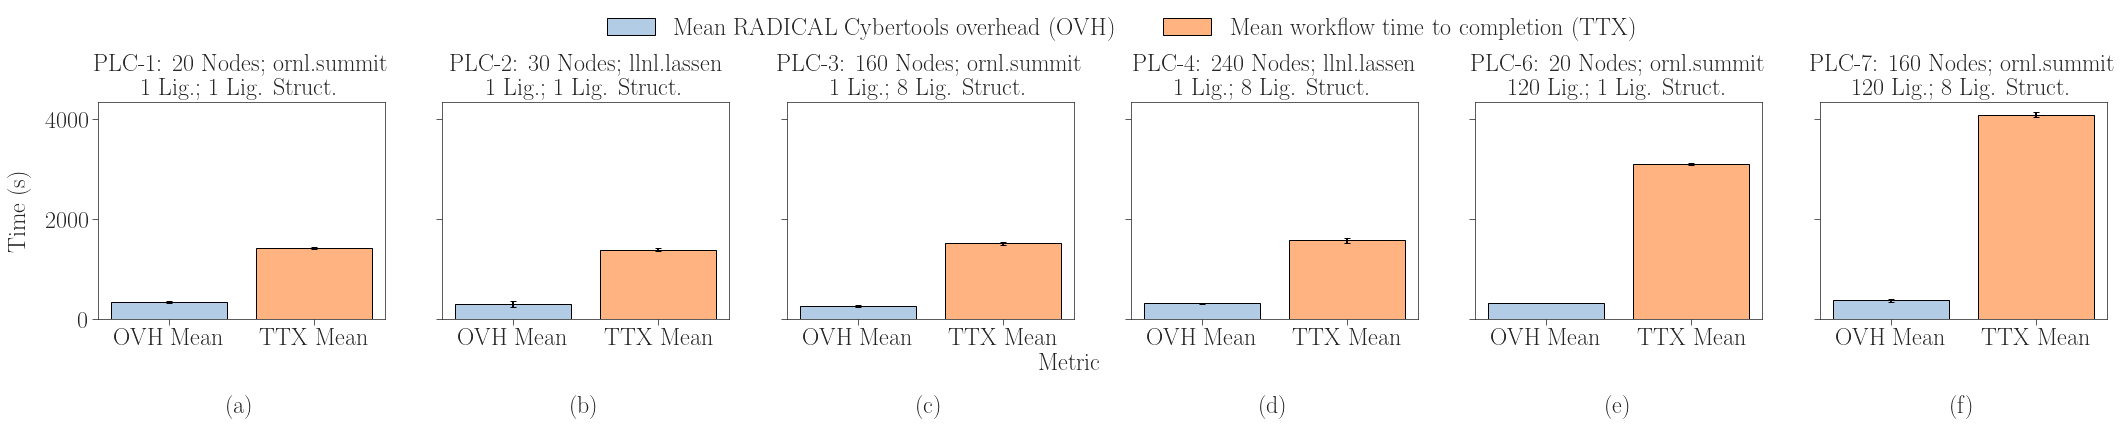

In [15]:
fwidth = 6*len(ovh_rtc.keys())
fhight = 4
fig, axarr = plt.subplots(1, len(ovh_rtc.keys()), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for expid in ovh_rtc.keys():
    if len(ovh_rtc.keys()) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s: %s Nodes; %s\n%s Lig.; %s Lig. Struct.' % (
        expid, 
        int(df_info[df_info['exp_id'] == expid]['nodes'].mean()),
        df_info[df_info['exp_id'] == expid]['resource'].tolist()[0],
        df_exp_design[df_exp_design['exp_id'] == expid]['lig'].tolist()[0],
        df_exp_design[df_exp_design['exp_id'] == expid]['ligstruct'].tolist()[0]))

    ax.bar(x = 'OVH Mean', 
           height = df_pcl_overheads[df_pcl_overheads['Exp. ID'] == expid]['OVH Mean'], 
           yerr = df_pcl_overheads[df_pcl_overheads['Exp. ID'] == expid]['OVH STD'], 
           color = tableau20[1])
    ax.bar(x = 'TTX Mean', 
           height = df_pcl_overheads[df_pcl_overheads['Exp. ID'] == expid]['TTX Mean'], 
           yerr = df_pcl_overheads[df_pcl_overheads['Exp. ID'] == expid]['TTX STD'], 
           color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.09,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text( 0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['Mean RADICAL Cybertools overhead (OVH)', 'Mean workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.25), fontsize=24, ncol=2)

plt.savefig('figures/paper_12122020_pcl-123467_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_12122020_pcl-123467_ovh_ttx.png', dpi=300, bbox_inches='tight')

# Overheads ExperimentS: PCL-1; PCL-3

In [16]:
skip = [
        're.session.lassen708.lee1078.018635.0004',   # PLC-2
        're.session.lassen709.lee1078.018640.0000',   # PLC-2
        're.session.lassen709.lee1078.018638.0001',   # PLC-2
        're.session.lassen708.lee1078.018606.0011',   # PLC-4
        're.session.lassen709.lee1078.018638.0002',   # PLC-4
        're.session.lassen709.lee1078.018640.0002',   # PLC-4
        're.session.login1.hrlee.018638.0001',        # PLC-6
        're.session.login1.hrlee.018638.0002',        # PLC-6
        're.session.login1.hrlee.018638.0003',        # PLC-6
        're.session.login1.hrlee.018638.0010',        # PLC-7
        're.session.login1.hrlee.018638.0011',        # PLC-7
        're.session.login1.hrlee.018638.0012',        # PLC-7
]
nnodes = {}

for s in ss:
    if s in skip:
        continue
    
    nns = int(ss[s]['nnodes'])
    ovh_rtc = ss[s]['ovh_rtc']
    ttx_u = ss[s]['ttx_u']
    nt = ss[s]['nunit']
    if nns not in nnodes.keys():
        nnodes[nns] = {'OVH': [ovh_rtc]}
        nnodes[nns]['TTX'] = [ttx_u]
        nnodes[nns]['ntask'] = [nt]
    else:
        nnodes[nns]['OVH'].append(ovh_rtc)
        nnodes[nns]['TTX'].append(ttx_u)
        nnodes[nns]['ntask'].append(nt)

for nns in nnodes.keys():
    nnodes[nns]['OVH_mean'] = np.mean(nnodes[nns]['OVH'])
    nnodes[nns]['TTX_mean'] = np.mean(nnodes[nns]['TTX'])
    nnodes[nns]['ntask_mean'] = np.mean(nnodes[nns]['ntask'])
    nnodes[nns]['OVH_std'] = np.std(nnodes[nns]['OVH'])
    nnodes[nns]['TTX_std'] = np.std(nnodes[nns]['TTX'])

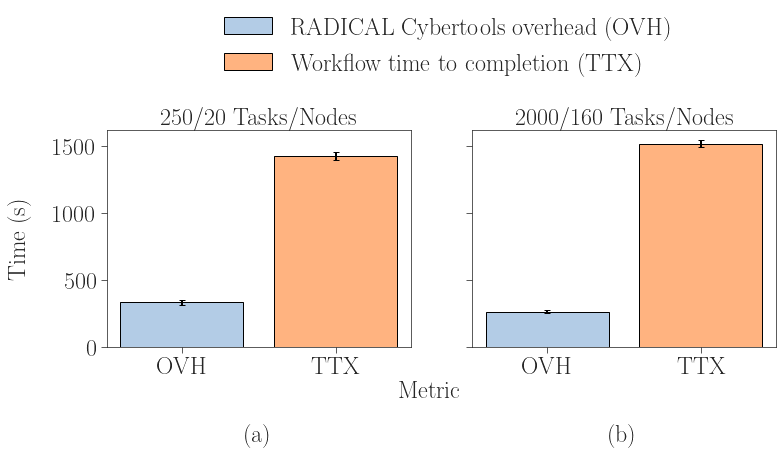

In [17]:
fwidth = 6*len(nnodes.keys())
fhight = 4
fig, axarr = plt.subplots(1, len(nnodes.keys()), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for nns in nnodes.keys():
    if len(nnodes.keys()) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (int(nnodes[nns]['ntask_mean']), nns))

    ax.bar(x = 'OVH', height = nnodes[nns]['OVH_mean'], yerr = nnodes[nns]['OVH_std'], color = tableau20[1])
    ax.bar(x = 'TTX', height = nnodes[nns]['TTX_mean'], yerr = nnodes[nns]['TTX_std'], color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.01,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text( 0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.35), fontsize=24, ncol=1)

plt.savefig('figures/paper_12122020_pcl1-3_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_12122020_pcl1-3_ovh_ttx.png', dpi=300, bbox_inches='tight')

# Overheads ExperimentS: PCL-2; PCL-4

In [18]:
skip = [
        're.session.login2.hrlee.018599.0001',        # PLC-1
        're.session.login5.hrlee.018606.0000',        # PLC-1
        're.session.login1.hrlee.018610.0002',        # PLC-1
        're.session.login1.hrlee.018610.0003',        # PLC-1
        're.session.login1.hrlee.018610.0005',        # PLC-1
        're.session.login2.hrlee.018602.0014',        # PLC-3
        're.session.login2.hrlee.018610.0008',        # PLC-3
        're.session.login2.hrlee.018610.0007',        # PLC-3
        're.session.login1.hrlee.018638.0001',        # PLC-6
        're.session.login1.hrlee.018638.0002',        # PLC-6
        're.session.login1.hrlee.018638.0003',        # PLC-6
        're.session.login1.hrlee.018638.0010',        # PLC-7
        're.session.login1.hrlee.018638.0011',        # PLC-7
        're.session.login1.hrlee.018638.0012',        # PLC-7
]
nnodes = {}

for s in ss:
    if s in skip:
        continue
    
    nns = int(ss[s]['nnodes'])
    ovh_rtc = ss[s]['ovh_rtc']
    ttx_u = ss[s]['ttx_u']
    nt = ss[s]['nunit']
    if nns not in nnodes.keys():
        nnodes[nns] = {'OVH': [ovh_rtc]}
        nnodes[nns]['TTX'] = [ttx_u]
        nnodes[nns]['ntask'] = [nt]
    else:
        nnodes[nns]['OVH'].append(ovh_rtc)
        nnodes[nns]['TTX'].append(ttx_u)
        nnodes[nns]['ntask'].append(nt)

for nns in nnodes.keys():
    nnodes[nns]['OVH_mean'] = np.mean(nnodes[nns]['OVH'])
    nnodes[nns]['TTX_mean'] = np.mean(nnodes[nns]['TTX'])
    nnodes[nns]['ntask_mean'] = np.mean(nnodes[nns]['ntask'])
    nnodes[nns]['OVH_std'] = np.std(nnodes[nns]['OVH'])
    nnodes[nns]['TTX_std'] = np.std(nnodes[nns]['TTX'])

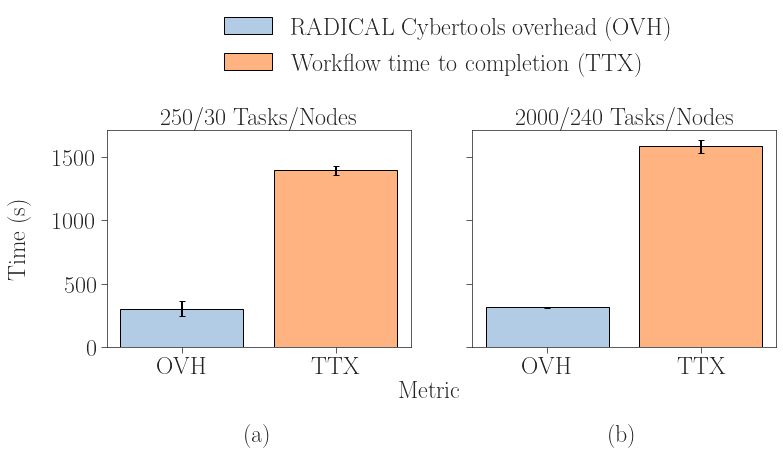

In [19]:
fwidth = 6*len(nnodes.keys())
fhight = 4
fig, axarr = plt.subplots(1, len(nnodes.keys()), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for nns in nnodes.keys():
    if len(nnodes.keys()) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (int(nnodes[nns]['ntask_mean']), nns))

    ax.bar(x = 'OVH', height = nnodes[nns]['OVH_mean'], yerr = nnodes[nns]['OVH_std'], color = tableau20[1])
    ax.bar(x = 'TTX', height = nnodes[nns]['TTX_mean'], yerr = nnodes[nns]['TTX_std'], color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.01,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text( 0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.35), fontsize=24, ncol=1)

plt.savefig('figures/paper_12122020_pcl2-4_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_12122020_pcl2-4_ovh_ttx.png', dpi=300, bbox_inches='tight')

# Overheads ExperimentS: PCL-6; PCL-7

In [20]:
skip = [
        're.session.login2.hrlee.018599.0001',        # PLC-1
        're.session.login5.hrlee.018606.0000',        # PLC-1
        're.session.login1.hrlee.018610.0002',        # PLC-1
        're.session.login1.hrlee.018610.0003',        # PLC-1
        're.session.login1.hrlee.018610.0005',        # PLC-1
        're.session.lassen708.lee1078.018635.0004',   # PLC-2
        're.session.lassen709.lee1078.018640.0000',   # PLC-2
        're.session.lassen709.lee1078.018638.0001',   # PLC-2
        're.session.login2.hrlee.018602.0014',        # PLC-3
        're.session.login2.hrlee.018610.0008',        # PLC-3
        're.session.login2.hrlee.018610.0007',        # PLC-3
        're.session.lassen708.lee1078.018606.0011',   # PLC-4
        're.session.lassen709.lee1078.018638.0002',   # PLC-4
        're.session.lassen709.lee1078.018640.0002',   # PLC-4
]
nnodes = {}

for s in ss:
    if s in skip:
        continue
    
    nns = int(ss[s]['nnodes'])
    ovh_rtc = ss[s]['ovh_rtc']
    ttx_u = ss[s]['ttx_u']
    nt = ss[s]['nunit']
    if nns not in nnodes.keys():
        nnodes[nns] = {'OVH': [ovh_rtc]}
        nnodes[nns]['TTX'] = [ttx_u]
        nnodes[nns]['ntask'] = [nt]
    else:
        nnodes[nns]['OVH'].append(ovh_rtc)
        nnodes[nns]['TTX'].append(ttx_u)
        nnodes[nns]['ntask'].append(nt)

for nns in nnodes.keys():
    nnodes[nns]['OVH_mean'] = np.mean(nnodes[nns]['OVH'])
    nnodes[nns]['TTX_mean'] = np.mean(nnodes[nns]['TTX'])
    nnodes[nns]['ntask_mean'] = np.mean(nnodes[nns]['ntask'])
    nnodes[nns]['OVH_std'] = np.std(nnodes[nns]['OVH'])
    nnodes[nns]['TTX_std'] = np.std(nnodes[nns]['TTX'])

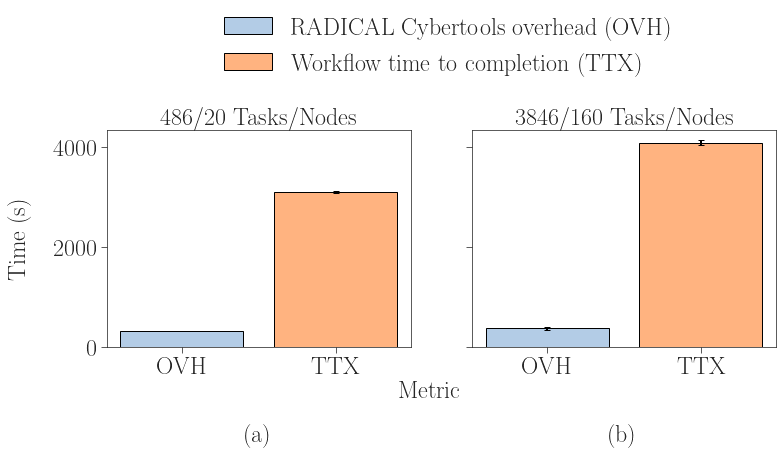

In [21]:
fwidth = 6*len(nnodes.keys())
fhight = 4
fig, axarr = plt.subplots(1, len(nnodes.keys()), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for nns in nnodes.keys():
    if len(nnodes.keys()) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (int(nnodes[nns]['ntask_mean']), nns))

    ax.bar(x = 'OVH', height = nnodes[nns]['OVH_mean'], yerr = nnodes[nns]['OVH_std'], color = tableau20[1])
    ax.bar(x = 'TTX', height = nnodes[nns]['TTX_mean'], yerr = nnodes[nns]['TTX_std'], color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.01,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text( 0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.35), fontsize=24, ncol=1)

plt.savefig('figures/paper_12122020_pcl6-7_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_12122020_pcl6-7_ovh_ttx.png', dpi=300, bbox_inches='tight')

In [22]:
metrics_default = [
    # pilot overheads (global)
    # ['Pilot Startup',     ['boot', 'setup_1']],
    # ['Pilot Termination', ['term' ]],

    # derived pilot durations
    # ['Agent Nodes',       ['agent']],
    # ['Warmup',            ['warm' ]],
    # ['Draining',          ['drain']],
    # ['Idle',              ['idle' ]],

    # unit durations
    # ['Prepare Exec',      ['exec_queue', 'exec_prep']],
    # ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
    ['Exec Cmd',          ['exec_cmd']],
    # ['Unschedule',        ['unschedule']],
]

In [23]:
# %%capture capt

# Remove cache to avoid reloading errors
! rm -r ~/.radical/analytics

# Skipe sessions we do not need to plot
skip = [
        '../data/raw/paper_12122020/re.session.login2.hrlee.018599.0001',        # PLC-1
        '../data/raw/paper_12122020/re.session.login5.hrlee.018606.0000',        # PLC-1
        '../data/raw/paper_12122020/re.session.login1.hrlee.018610.0002',        # PLC-1
        '../data/raw/paper_12122020/re.session.login1.hrlee.018610.0003',        # PLC-1
#       '../data/raw/paper_12122020/re.session.login1.hrlee.018610.0005',        # PLC-1
        '../data/raw/paper_12122020/re.session.lassen708.lee1078.018635.0004',   # PLC-2
#       '../data/raw/paper_12122020/re.session.lassen709.lee1078.018638.0001',   # PLC-2
        '../data/raw/paper_12122020/re.session.lassen709.lee1078.018640.0000',   # PLC-2
        '../data/raw/paper_12122020/re.session.login2.hrlee.018602.0014',        # PLC-3
#       '../data/raw/paper_12122020/re.session.login2.hrlee.018610.0007',        # PLC-3
        '../data/raw/paper_12122020/re.session.login2.hrlee.018610.0008',        # PLC-3
#       '../data/raw/paper_12122020/re.session.lassen709.lee1078.018638.0002',   # PLC-4
        '../data/raw/paper_12122020/re.session.lassen709.lee1078.018640.0002',   # PLC-4
        '../data/raw/paper_12122020/re.session.login1.hrlee.018638.0001',        # PLC-6
#       '../data/raw/paper_12122020/re.session.login1.hrlee.018638.0002',        # PLC-6
        '../data/raw/paper_12122020/re.session.login1.hrlee.018638.0003',        # PLC-6
        '../data/raw/paper_12122020/re.session.login1.hrlee.018638.0010',        # PLC-7
#       '../data/raw/paper_12122020/re.session.login1.hrlee.018638.0011',        # PLC-7
        '../data/raw/paper_12122020/re.session.login1.hrlee.018638.0012',        # PLC-7       
]
sids_pruned = np.setdiff1d(sids, skip)

sobjs = ra.Experiment(sids_pruned, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.lassen709.lee1078.018638.0001.pickle'
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.lassen709.lee1078.018638.0002.pickle'
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.login1.hrlee.018610.0005.pickle'
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.login1.hrlee.018638.0002.pickle'
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.login1.hrlee.018638.0011.pickle'
cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.login2.hrlee.018610.0007.pickle'


In [24]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

# zero points to zero the axes of the plot.
p_zeros = {}
for session in sobjs.sessions:
    for pilot in session.get(etype='pilot'):
        p_zeros[session.uid] = pilot.timestamps(event={ru.EVENT: 'bootstrap_0_start'})[0]

def update_ticks(x, pos):
    return int(x/168)

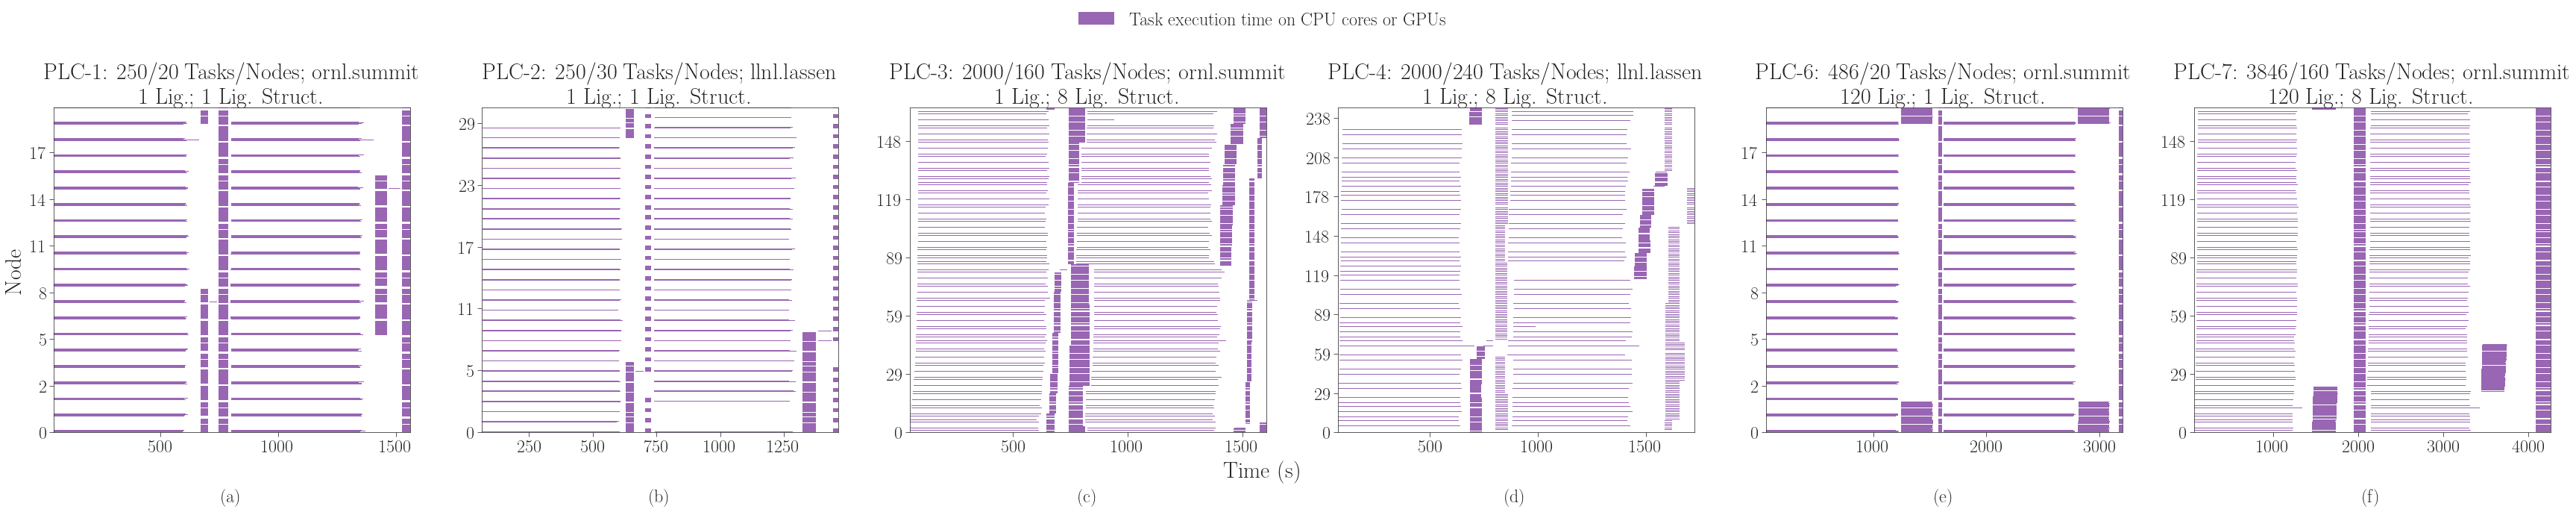

In [34]:
splot = [
#       're.session.login2.hrlee.018599.0001',        # PLC-1
#       're.session.login5.hrlee.018606.0000',        # PLC-1
#       're.session.login1.hrlee.018610.0002',        # PLC-1
#       're.session.login1.hrlee.018610.0003',        # PLC-1
        're.session.login1.hrlee.018610.0005',        # PLC-1
#       're.session.lassen708.lee1078.018635.0004',   # PLC-2
        're.session.lassen709.lee1078.018638.0001',   # PLC-2
#       're.session.lassen709.lee1078.018640.0000',   # PLC-2
#       're.session.login2.hrlee.018602.0014',        # PLC-3
        're.session.login2.hrlee.018610.0007',        # PLC-3
#       're.session.login2.hrlee.018610.0008',        # PLC-3
#       're.session.lassen708.lee1078.018606.0011',   # PLC-4
        're.session.lassen709.lee1078.018638.0002',   # PLC-4
#       're.session.lassen709.lee1078.018640.0002',   # PLC-4
#       're.session.login1.hrlee.018638.0001',        # PLC-6
        're.session.login1.hrlee.018638.0002',        # PLC-6
#       're.session.login1.hrlee.018638.0003',        # PLC-6
#       're.session.login1.hrlee.018638.0010',        # PLC-7
        're.session.login1.hrlee.018638.0011',        # PLC-7
#       're.session.login1.hrlee.018638.0012',        # PLC-7
]

nsids = len(splot)-1

fwidth = 12*nsids
fhight = 8
fig, axarr = plt.subplots(1, nsids+1, sharex='col', figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in splot:
    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=45)
    else:
        ax = axarr

    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.set_title(
        '%s: %s/%s Tasks/Nodes; %s\n%s Lig.; %s Lig. Struct.' % (
            ss[sid]['expid'],
            ss[sid]['nunit'], 
            int(ss[sid]['nnodes']),
            df_info[df_info['exp_id'] == ss[sid]['expid']]['resource'].tolist()[0],
            df_exp_design[df_exp_design['exp_id'] == ss[sid]['expid']]['lig'].tolist()[0],
            df_exp_design[df_exp_design['exp_id'] == ss[sid]['expid']]['ligstruct'].tolist()[0]), 
        fontdict={'fontsize': 30})

    for metric in metrics_default:

        color = tableau20[8] #cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0] - p_zeros[sid]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    # ax.set_xlabel('Time (s)', fontsize=30)
    # ax.set_ylabel('Node', fontsize=30)
    
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)
    
# Add legend
# ax.legend(legend, [m[0] for m in metrics_default], loc='upper center', fontsize=30, ncol=4, bbox_to_anchor=( -0.5, 1.35))
fig.legend(['Task execution time on CPU cores or GPUs'], loc='upper center', bbox_to_anchor=(0.5, 1.14), fontsize=24, ncol=1)
fig.text( 0.11,  0.5 , 'Node'    , va='center', rotation='vertical', fontsize=30)
fig.text( 0.5,  0.02, 'Time (s)', ha='center', fontsize=30)

plt.savefig('figures/paper_12122020_ru.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_12122020_ru.png', dpi=300, bbox_inches='tight')